In [1]:
# Numerical computation 
import numpy as np
# Read data
import pandas as pd 
# DL
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
# Others 
import os 
import time

Using TensorFlow backend.


### Load Data 
Read data and store it in a dataframe. Then, use df.head() to show the first rows of the dataset. 

In [30]:
def get_stock_data(stock_name, normalized=0):
    url = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv' % stock_name

    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    date_split = df['Date'].str.split('-').str
    df['Year'], df['Month'], df['Day'] = date_split
    df["Volume"] = df["Volume"] / 10000
    df.drop(df.columns[[0,3,5,6, 7,8,9]], axis=1, inplace=True) 
    return df

In [31]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name,0)
df.head()

,Open,High,Close
0,841.039978,843.729980,840.179993
1,838.460022,843.719971,841.460022
2,841.700012,844.630005,839.880005
3,841.539978,846.739990,841.700012
4,845.000000,845.880005,842.099976


### EDA
The data has very high values. That will diminish the statistical efficiency. We have to apply feature scaling. 

In [32]:
df['High'] = (df['High'] - np.amin(df['High'])) / (np.amax(df['High']) - np.amin(df['High']))
df['Open'] = (df['Open'] - np.amin(df['Open'])) / (np.amax(df['Open']) - np.amin(df['Open']))
df['Close'] = (df['Close'] - np.amin(df['Close'])) / (np.amax(df['Close']) - np.amin(df['Close']))
df.head(5)

,Open,High,Close
0,0.469789,0.471383,0.474506
1,0.466243,0.471370,0.476276
2,0.470697,0.472619,0.474091
3,0.470477,0.475515,0.476608
4,0.475232,0.474334,0.477161



As we can see, the dataset is very small. There is no much space to create a train and a test set. We will have to use 80/20 to split the data. 

In [33]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [34]:
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1185, 22, 3)
y_train (1185,)
X_test (132, 22, 3)
y_test (132,)


In [35]:
def build_model(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16,init='uniform',activation='relu'))        
    model.add(Dense(1,init='uniform',activation='linear'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

In [36]:
model = build_model([3, window, 1])

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, kernel_initializer="uniform", activation="relu")`
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", activation="linear")`


### Training 
Adjust hyperparameters and train the model.

In [38]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=30,
    validation_split=0.1,
    verbose=1)

C:\Users\HP\Anaconda3\lib\site-packages\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1066 samples, validate on 119 samples
Epoch 1/30
1066/1066 [==============================] - 9s - loss: 0.0024 - acc: 0.0019 - val_loss: 5.1056e-04 - val_acc: 0.0000e+00
Epoch 2/30
1066/1066 [==============================] - 7s - loss: 0.0022 - acc: 0.0019 - val_loss: 4.6085e-04 - val_acc: 0.0000e+00
Epoch 3/30
1066/1066 [==============================] - 7s - loss: 0.0021 - acc: 0.0019 - val_loss: 5.2971e-04 - val_acc: 0.0000e+00
Epoch 4/30
1066/1066 [==============================] - 6s - loss: 0.0024 - acc: 0.0019 - val_loss: 6.2834e-04 - val_acc: 0.0000e+00

In [39]:
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

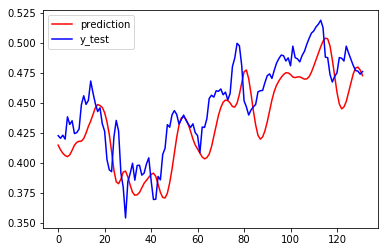

In [40]:
import matplotlib.pyplot as plt

plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()